# TTC Subway Delays

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
%matplotlib inline
sns.set()
%matplotlib inline

# 1. Data Collection and Cleaning

## a. Data Types
- High Level Overview of Data Types

## b. Missing Data
- Bound
- Line
- Code Names

## c. Feature Engineering
- Station Engineering
- Line Completion and Verification
- Location (Station/Misc)
- Code Bins

## d. Monthly Ridership
- Import and Cleaning

# 2. Data Analysis

## a. High Level Overview of Delays
- Types of Delays
- Occurence of Delays

## b. Efficiency Metrics and Trends
- Efficiency Metrics
- Efficiency Trends

## c. Correlation between Min Delay and Min Gap


# 1. Data Collection and Cleaning

## a. High Level Overview of Data

In [2]:
# Import datasets
delay = pd.read_csv('data/all_years.csv', delimiter = '\t')
codes_srt = pd.read_csv('data/codes_srt.csv', delimiter = '\t')
codes_sub = pd.read_csv('data/codes_sub.csv', delimiter = '\t')

# Merge Datasets
delay = pd.merge(left=delay, right=codes_srt, how='left', left_on=delay['Code'], 
        right_on=codes_srt['SRT RMENU CODE']).drop(columns='key_0',axis=1)

delay = pd.merge(left=delay, right=codes_sub, how='left', 
                left_on=delay['Code'], right_on=codes_sub['SUB RMENU CODE']).drop(columns='key_0', axis=1)

# Create combo code columns
delay['reason'] = delay['CODE DESCRIPTION_y'].fillna(delay['CODE DESCRIPTION_y'])
delay = delay.rename(columns={'reason_y': 'reason'})

# Drop data fields that are repetitive
delay = delay.drop(columns=['SRT RMENU CODE','CODE DESCRIPTION_x','SUB RMENU CODE', 
                   'CODE DESCRIPTION_y'])

In [3]:
# What does our data look like?
delay.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,reason
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,Priority One - Train in Contact With Person
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,Disorderly Patron
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0,NaN
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,Disorderly Patron
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,Unsanitary Vehicle


In [4]:
# What types of data are we working with?
delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97677 entries, 0 to 97676
Data columns (total 11 columns):
Date         97677 non-null object
Time         97677 non-null object
Day          97677 non-null object
Station      97677 non-null object
Code         97676 non-null object
Min Delay    97677 non-null int64
Min Gap      97677 non-null int64
Bound        76575 non-null object
Line         97277 non-null object
Vehicle      97677 non-null int64
reason       91956 non-null object
dtypes: int64(3), object(8)
memory usage: 8.9+ MB


In [5]:
# Convert date/time columns
delay['Date'] = pd.to_datetime(delay['Date'])
# Generate ['Year','Month'] columns
delay['Year'] = delay['Date'].apply(lambda x: x.year)
delay['Month'] = delay['Date'].apply(lambda x: x.month)

In [6]:
# Generate Hour column
delay['Time'] = pd.to_datetime(delay['Time'])
delay['Hour'] = delay['Time'].apply(lambda x: x.hour)

In [7]:
# Reformat all columns
delay.columns = [col.replace(' ','_').lower() for col in delay.columns.tolist()]

## b. Missing Data

Text(0.5,0,'Percent of Values Missing (%)')

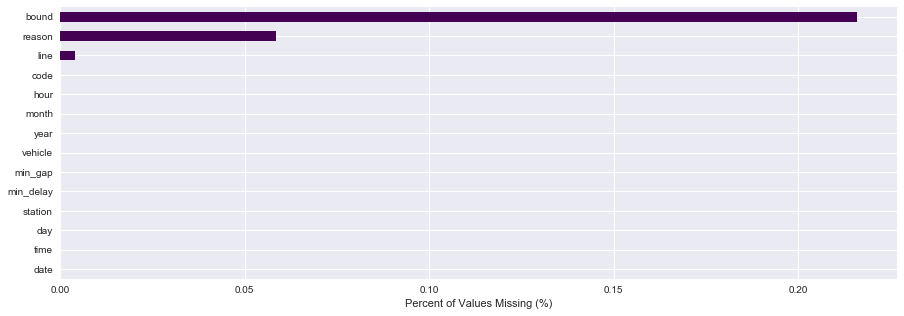

In [8]:
# What data are we missing?
# What data are we missing
ax = delay.isnull().mean().sort_values().plot(kind='barh',figsize=(15,5), colormap='viridis')
ax.set_xlabel('Percent of Values Missing (%)')

### Bound: 21.6% Missing 

- Directional in either one direction or the other.
- Nulls can be expected as some delays are when subways are not in transit.
- 50/50 chance of generating the accurate direction.
- Complete Nulls with 'NA'

### Reason: 5.9% Missing
- While combo codes are available for all data points, not all combo codes were mapped to a combo name in the attached dataset.
- Cannot be completed with anything beyond 'Misc'
- Do we want to drop missing or fill with 'Misc'

### Line: 0.4% Missing
- Small number of missing values
- Can be completed based on station estimates

In [9]:
# Complete missing values if possible
delay['bound'] = delay['bound'].fillna('NA')
delay['reason'] = delay['reason'].fillna('Misc')

## c. Feature Engineering

### Station:

Levenshtein Distance
- Identifies the number of characters needed to change in order to generate two identical strings.

Logic:
- First, identify if an identical string is matched with the structured list of TTC Stations.
- Second, split the station name into a list of words, and identify if any individual word matches a station name directly. This matches the first station avaialble in the list.
- Finally, iterate through the station names, and compare seperate sections of strings against the station names listed to identify the closest station affiliate.

In [10]:
# Station Engineering

# Generate station Dictionary and List
stationDict =  {'BD': ['Bloor','St George','Spadina','Kipling','Islington','Royal York','Old Mill','Jane','Runnymede','High Park','Keele','Dundas West','Lansdowne','Dufferin','Ossington','Christie','Bathurst','Bay','Sherbourne','Castle Frank','Broadview','Chester','Pape','Donlands','Greenwood','Coxwell','Woodbine','Main Street','Victoria Park','Warden'],
               'YU': ['Finch','North York Centre','York Mills','Lawrence','Eglinton','Davisville','St Clair','Summerhill','Rosedale','Wellesley','College','Dundas','Queen','King','Union','St Andrew','Osgoode','St Patrick','Queens Park','Museum','Dupont','St Clair West','Eglinton West','Glencairn','Lawrence West','Yorkdale','Wilson','Sheppard West','Downsview Park','Finch West','York University','Pioneer Village','Highway 407','Vaughan Metro Centre','Bloor','St George','Spadina','Sheppard'],
               'SHP': ['Sheppard','Bayview','Bessarion','Leslie','Don Mills'],
               'SRT': ['Kennedy','Lawrence East','Ellesmere','Midland','Scarborough Centre','McCowan']}

stationList = []
for line in stationDict:
    for stat in stationDict[line]:
        stationList.append(stat.lower())
    
    
stationList = list(set(stationList))                

In [11]:
# Identify Levenshtein Distance of Variables
# https://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/

def lev(string1, string2):
    size_x = len(string1) + 1
    size_y = len(string2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = 0
    for y in range(size_y):
        matrix [0, y] = y
    
    for x in range(1, size_x):
        for y in range(1, size_y):
            if string1[x-1] == string2[y-1]:
                matrix [x, y] = min(
                matrix[x-1, y] + 1,
                matrix[x-1, y-1],
                matrix[x, y-1] + 1)
            else:
                matrix[x,y] = min(
                matrix[x-1,y-1] + 1,
                matrix[x, y-1] + 1)

    #print(matrix)
    return (matrix[size_x - 1, size_y-1])

In [12]:
# Create Function to Morph Station to Closes Variable in Station List

# Identify list of variables to replace
replaceList = ['-','_','.','-']

def morphName(string, stationList):
    
    for r in replaceList:
        string = string.replace(r,'')
    
    #1. Identify if 'Station' is in string
    val = string.lower().find('station')
    if val != -1:
        
        for station in stationList:
            if lev(string[:val-1].replace(' ','').lower(), station.replace(' ','').lower()) == 0:
                return station
            
    #2. Use Bag of Words method
    if val != -1:
        searchList = string[:val-1].split(' ')
    else:
        searchList = string.split(' ')
        
    for word in searchList:
        for station in stationList:
            if lev(word.lower(), station) == 0:
                return station
            
    #3. Use closest approximate
    if val != -1:
        search = string[:val-1].replace(' ','').lower()
        for station in stationList:
            
            target = station.replace(' ','')

            for i in reversed(range(3, len(search) + 1)):
                if len(search[:i]) <= len(target):
                    if lev(search[:i], target[:i]) == 0:
                        return station

In [13]:
# Generate Mapping Table for Station Names

data_station = []
real_station = []

# Cycle through station names to identify the closest match
for stat in delay['station'].unique():
    data_station.append(stat)
    real_station.append(morphName(stat, stationList))
    
# Concatenate Series into Dataframe
stationNames = pd.concat([pd.Series(data_station, name='data_station'), 
                          pd.Series(real_station, name='real_station')], 
                          axis=1)

In [14]:
# Merge Station Names to Delay
delay = pd.merge(left=delay, right=stationNames, how='left',
                left_on=delay['station'], right_on=stationNames['data_station']).drop(columns=['key_0','data_station'],axis=1)


### Line Completion and Verification:

In [15]:
# Fill Line NaN with Lines based on Engineered Station
# Do not fill in lines if its at a bridge station
lineDict = {}
bridgeList = ['bloor','st george','sheppard']

for line in stationDict:
    for station in stationDict[line]:
        if station.lower() not in bridgeList:
            lineDict[station.lower()] = line

delay['real_line'] = delay['real_station'].map(lineDict)    

delay['line'] = delay['line'].fillna(delay['real_station'].map(lineDict))

# Completed reduces the NA's from 400 to 153

### Location:
- Engineer Location/Misc Boolean to identify if the delay happened to occur at a station

In [16]:
# Create Location field
delay['location'] = delay['station'].apply(lambda x: 'Station' if 'station' in x.lower() else 'Misc')

### Code Bins
- Engineer groupings for codes based on offline mapping solution prepared manually.
- Due to intricacy of the data, no programmatic solution is available to bin.

In [17]:
# Import bins
codes_bins = pd.read_csv('data/codes_bins.csv')

# Merge Code bins into data
delay = pd.merge(how='left', left=delay, right=codes_bins, left_on=['reason'], right_on=['combo code']).drop(columns=['combo code'], axis=1)
delay = delay.rename(columns={'code bin': 'code_bin'})

In [65]:
# Convert Min Delay to Min Delay Hours
delay['Min Delay Hours'] = delay['min_delay']/60

In [66]:
delay.head()

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,reason,year,month,hour,real_station,real_line,location,code_bin,Min Delay Hours
0,2014-01-01,2018-12-11 00:21:00,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,Priority One - Train in Contact With Person,2014,1,0,victoria park,BD,Station,Accident,0.916667
1,2014-01-01,2018-12-11 02:06:00,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,Disorderly Patron,2014,1,2,high park,BD,Station,Disorderly Patron,0.050000
2,2014-01-01,2018-12-11 02:40:00,Wednesday,SHEPPARD STATION,MUNCA,0,0,NA,YU,0,Misc,2014,1,2,sheppard,NaN,Station,Misc,0.000000
3,2014-01-01,2018-12-11 03:10:00,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,Disorderly Patron,2014,1,3,lansdowne,BD,Station,Disorderly Patron,0.050000
4,2014-01-01,2018-12-11 03:20:00,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,Unsanitary Vehicle,2014,1,3,bloor,NaN,Station,Unsantiary Vehicle,0.083333


## d. Monthly Ridership

### Import and Clean Data

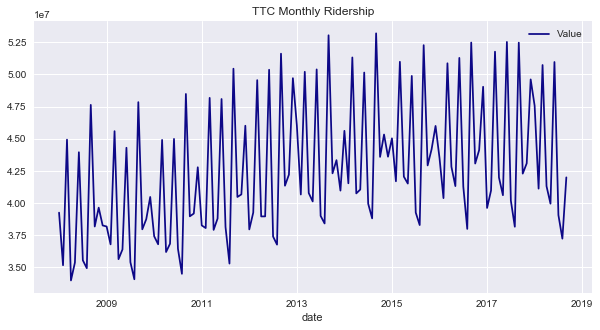

In [67]:
# Import ridership data
riders = pd.read_csv('data/monthly_ridership.csv')

# Plot Ridership Details
riders['date'] = pd.to_datetime(riders['Year'].astype(str) + riders['Period'], format='%Y%b')
riders.set_index(['date'], inplace=True)
riders = riders.drop(columns='Year', axis=1)
riders.plot(colormap='plasma', title="TTC Monthly Ridership", figsize=(10,5))

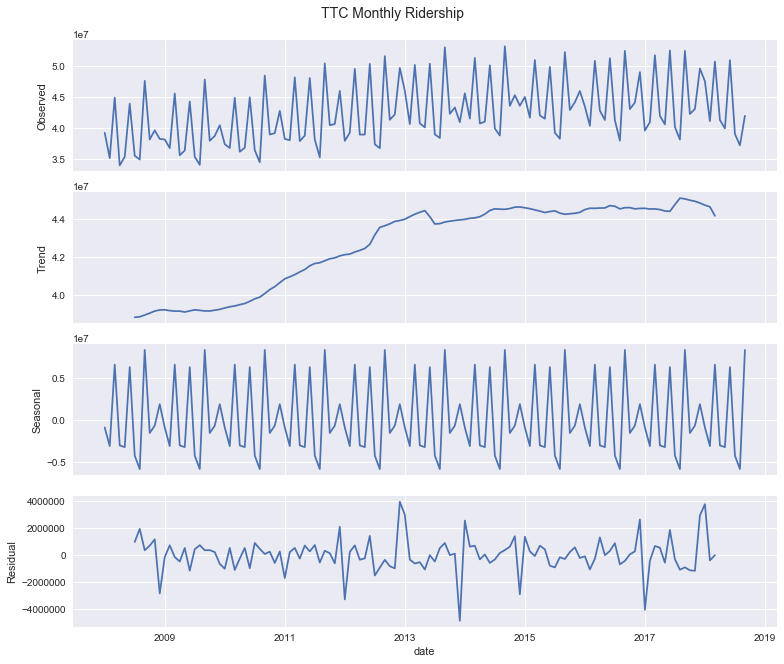

In [68]:
# Seasonality ridership data
# Import ridership data
riders = pd.read_csv('data/monthly_ridership.csv')

# Plot Ridership Details
riders['date'] = pd.to_datetime(riders['Year'].astype(str) + riders['Period'], format='%Y%b')
riders.set_index(['date'], inplace=True)

rcParams['figure.figsize'] = 11,9

decomposition = sm.tsa.seasonal_decompose(riders['Value'], model='additive')
fig = decomposition.plot()
plt.set_cmap('plasma')
plt.suptitle(t='TTC Monthly Ridership', y=1.02, fontsize=14)
plt.show()

# 2. Data Analysis

## a. High Level Overview of Delays

### Distribution of Delay Times

C:\Users\kyleb\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


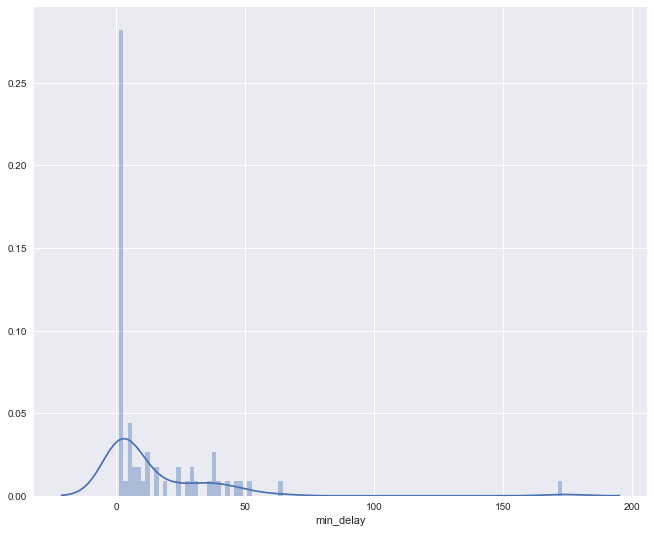

In [69]:
p = delay[delay['code_bin']=='Fire/Smoke']['min_delay'].value_counts()
#p.plot(kind='hist', bins=100, )
sns.distplot(a=p, hist=True, kde=True, bins=100)
#sns.distplot(a=delay[delay['code_bin']=='Fire/Smoke']['min_delay'].value_counts(), hist=True, vertical=False)

### High Level Analysis of Min Delays

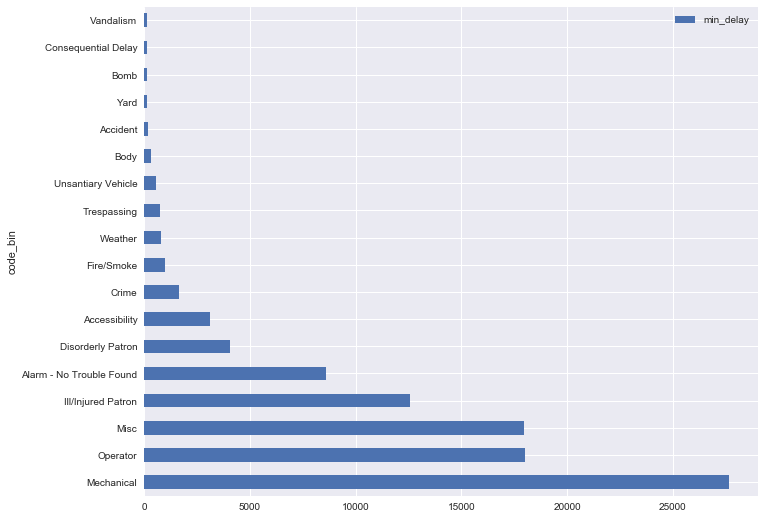

In [70]:
# What types of delays are most commonly reported?
delay[['code_bin','min_delay']].groupby(['code_bin']).count().sort_values('min_delay', ascending=False).plot(kind='barh')

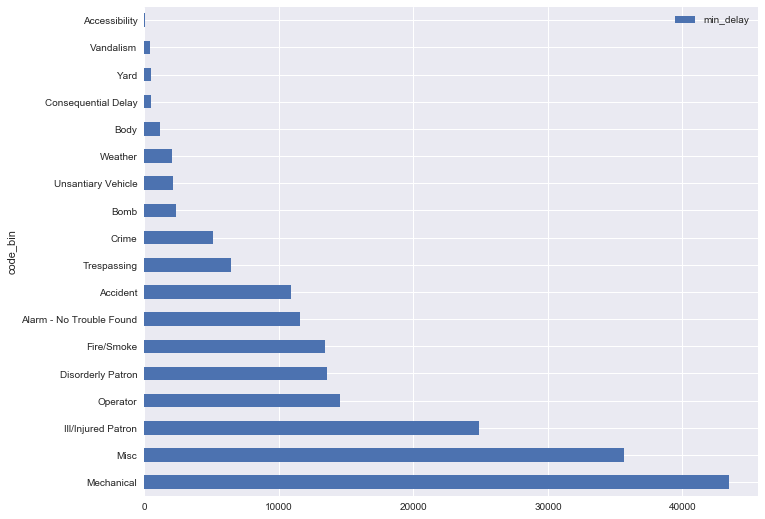

In [71]:
# What types of delays are causing the greatest service delays?
delay[['code_bin','min_delay']].groupby(['code_bin']).sum().sort_values('min_delay',ascending=False).plot(kind='barh')

In [72]:
# Identify the Min/Max/Mean of Min Delay for Each Code Bin
df1 = delay[['code_bin','min_delay']].groupby('code_bin').mean()
df2 = delay[['code_bin','min_delay']].groupby('code_bin').median()
df3 = delay[['code_bin','min_delay']].groupby('code_bin').max()
df4 = delay[['code_bin','min_delay']].groupby('code_bin').min()

df1 = pd.merge(how='left',left=df1,right=df2,left_on=df1.index, right_on=df2.index, left_index=True,right_index=True)
df1 = df1.rename(columns={'min_delay_x': 'mean', 'min_delay_y': 'median'})

df1 = pd.merge(how='left',left=df1,right=df3,left_on=df1.index, right_on=df3.index, left_index=True,right_index=True)
df1 = df1.rename(columns={'min_delay': 'max'})

df1 = pd.merge(how='left',left=df1,right=df4,left_on=df1.index, right_on=df4.index, left_index=True,right_index=True)
df1 = df1.rename(columns={'min_delay': 'min'})

df1.sort_values('mean', ascending=False)

,mean,median,max,min
code_bin,,,,
Accident,67.370370,59,452,0
Bomb,18.452381,9,195,0
Fire/Smoke,13.601015,10,575,0
Trespassing,8.627164,6,137,0
Consequential Delay,4.290323,4,15,0
Unsantiary Vehicle,3.776577,4,27,0
Vandalism,3.638655,4,21,0
Body,3.629393,3,15,0
Yard,3.609589,4,14,0


### High Level Analysis of Minimum Gap

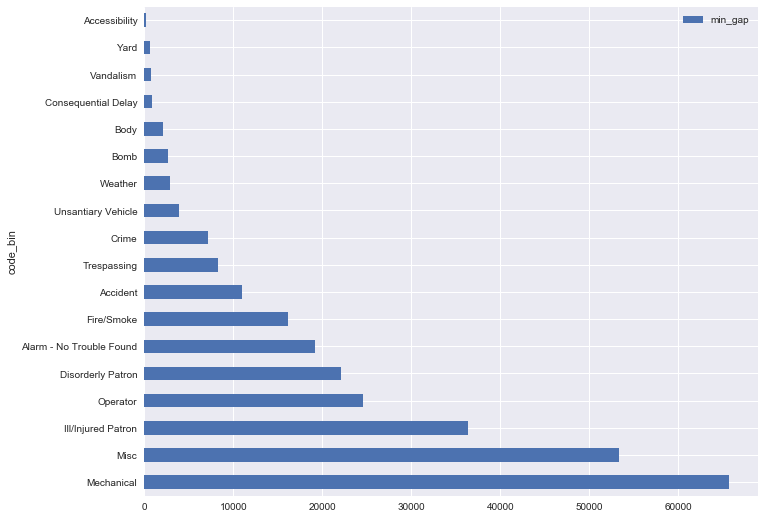

In [73]:
# What types of delays are causing the greatest service disruption between two trains?
delay[['code_bin','min_gap']].groupby(['code_bin']).sum().sort_values('min_gap', ascending=False).plot(kind='barh')

### Seasonality of Minimum Delays

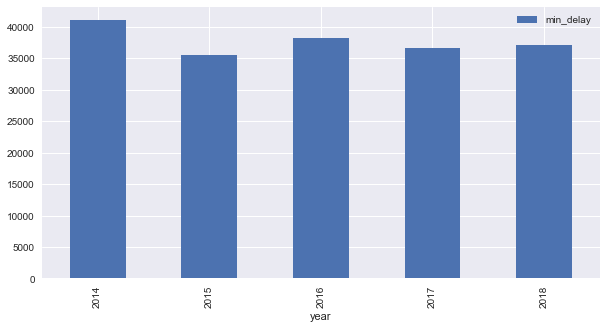

In [74]:
# What are the trends by Year
sns.set(rc={'figure.figsize':(10,5)})
delay[['year','min_delay']].groupby('year').sum().plot(kind='bar')

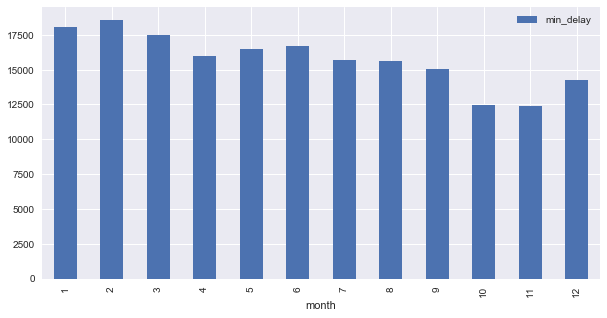

In [75]:
# What are the trends by months
delay[['month','min_delay']].groupby('month').sum().plot(kind='bar')

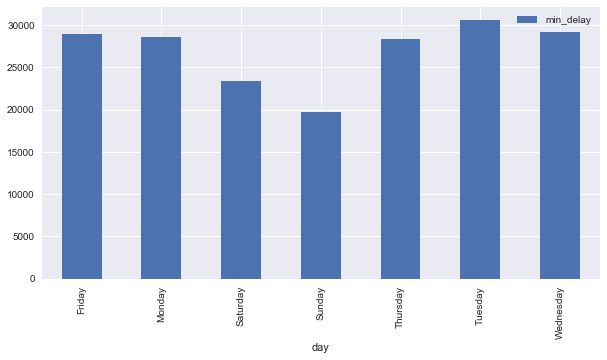

In [76]:
# What are the trends by weekday
delay[['day','min_delay']].groupby('day').sum().plot(kind='bar')

### Slowest and Fastest Stations

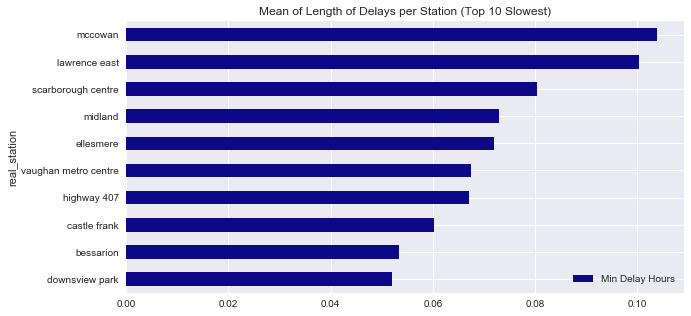

In [77]:
# What are the slowest stations?
list_of_stations = delay['real_station'].unique()

summary_df = delay.copy()
summary_df.groupby(['real_station']).agg({'Min Delay Hours': np.mean}).sort_values([('Min Delay Hours')]).tail(10).plot(kind='barh',
                                                                                                                        colormap='plasma',
                                                                                                                        title = 'Mean of Length of Delays per Station (Top 10 Slowest)')

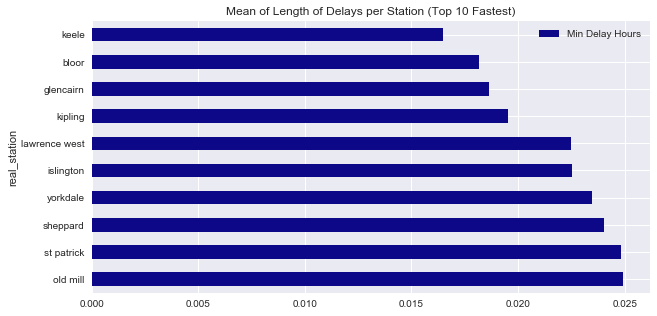

In [78]:
# What are the fastest stations
list_of_stations = delay['real_station'].unique()

summary_df = delay.copy()
summary_df.groupby(['real_station']).agg({'Min Delay Hours' : np.mean}).sort_values(by='Min Delay Hours', ascending=False).tail(10).plot(kind='barh',
                                                                                                                                colormap='plasma',
                                                                                                                                title='Mean of Length of Delays per Station (Top 10 Fastest)')

### Identify Distribution of Delays

(0, 10)

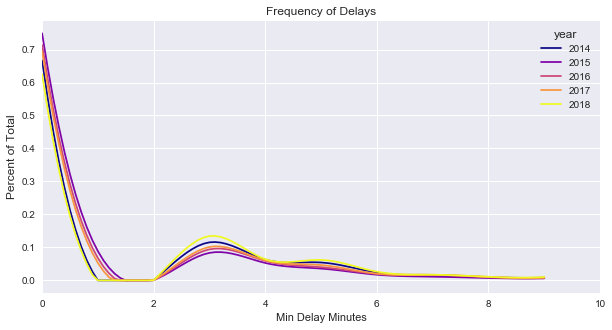

In [79]:
from scipy.interpolate import spline

def set_negatives_to_zero(float):
    if (float < 0):
        return 0.0
    
list_of_lines = delay['real_line'].unique()

unique_code_bins = delay['code_bin'].unique()
unique_code_bins = [x for x in unique_code_bins if str(x) != 'nan']
summary_df = delay.copy()
summary_df = summary_df.dropna()

summary_df['Min Delay Minutes'] = summary_df['Min Delay Hours'] * 60
summary_df['count'] = summary_df.groupby(['Min Delay Minutes','year'])['Min Delay Minutes'].transform('count')

summary_df = summary_df.drop_duplicates(subset=['Min Delay Minutes', 'year']).sort_values(['count']).dropna()

#summary_df.head(500)

summary_df['normalized_count'] = summary_df['count']/summary_df.groupby('year')['count'].transform('sum')
summary_df = summary_df.sort_values(['normalized_count']).pivot("Min Delay Minutes", "year", "normalized_count")

new_index = np.arange(0.0,10.0,0.1)
new_df = summary_df.reindex(new_index).reset_index()
new_df = new_df.interpolate(method='cubic')
new_df = new_df.set_index('Min Delay Minutes')
new_df[new_df < 0] = 0

data_frame = new_df.plot(kind='line', colormap='plasma', title="Frequency of Delays", figsize=(10,5), )
data_frame.set_ylabel("Percent of Total", fontsize=12)
data_frame.set_xlim(0,10)

### Frequency of All Incidents by Line

Text(0,0.5,'Code')

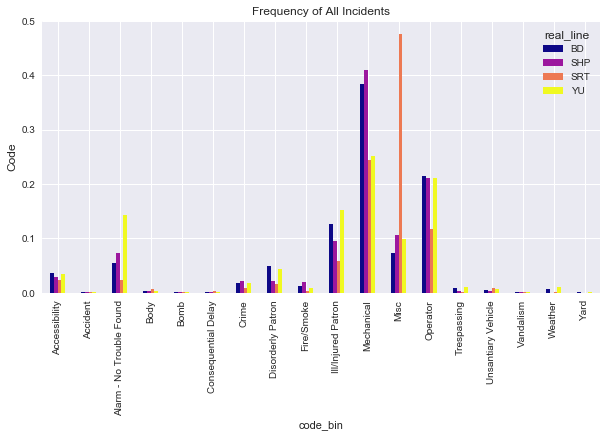

In [80]:
list_of_lines = delay['real_line'].unique()

unique_code_bins = delay['code_bin'].unique()
unique_code_bins = [x for x in unique_code_bins if str(x) != 'nan']
summary_df = delay.copy()
summary_df['count'] = summary_df.groupby(['code_bin', 'real_line'])['code_bin'].transform('count')

summary_df = summary_df.drop_duplicates(subset=['code_bin','real_line']).sort_values(['count']).dropna()

summary_df['normalized_count'] = summary_df['count']/summary_df.groupby('real_line')['count'].transform('sum')

summary_df = summary_df.sort_values(['normalized_count']).pivot("code_bin", "real_line", "normalized_count")
data_frame = summary_df.plot(kind='bar', colormap='plasma', title='Frequency of All Incidents', figsize=(10,5))
data_frame.set_ylabel('Code', fontsize=12)

### Time Analysis

Text(0,0.5,'Code')

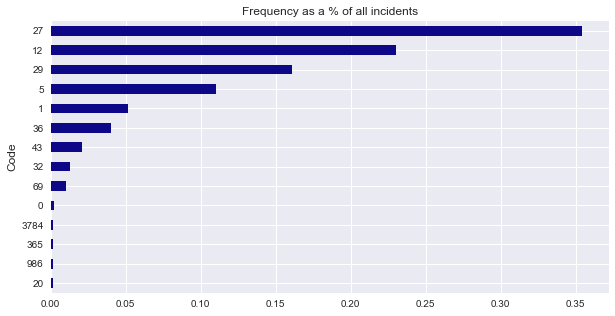

In [81]:
# Frequency based upon time
unique_code_bins = delay['code_bin'].unique()
unique_code_bins = [x for x in unique_code_bins if str(x) != 'nan']
summary_df = delay.copy()

summary_df['count'] = summary_df.groupby(['code_bin'])['code_bin'].transform('count')
summary_df = summary_df.drop_duplicates(subset=['code_bin']).sort_values(['count']).dropna()
summary_df = summary_df['count'] / summary_df['count'].sum()
data_frame = summary_df.plot(kind='barh', x='code_bin', y='count', colormap='plasma', title = 'Frequency as a % of all incidents', figsize=(10,5))
data_frame.set_ylabel('Code',fontsize=12)

Text(0,0.5,'Frequency')

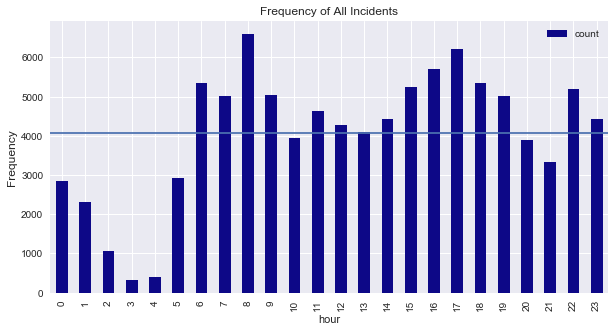

In [84]:
summary_df = delay.copy()

summary_df['count'] = summary_df.groupby(['hour'])['hour'].transform('count')
summary_df = summary_df.drop_duplicates(subset=['hour']).sort_values(['hour'])
data_frame = summary_df.plot(kind='bar', x='hour',y='count', colormap='plasma',title='Frequency of All Incidents', figsize=(10,5))
data_frame.axhline(y=summary_df['count'].mean())
data_frame.set_ylabel('Frequency', fontsize=12)

[Text(0,0,'Jan'),
 Text(0,0,'Feb'),
 Text(0,0,'March'),
 Text(0,0,'Apr'),
 Text(0,0,'May'),
 Text(0,0,'June'),
 Text(0,0,'July'),
 Text(0,0,'Aug'),
 Text(0,0,'Sept'),
 Text(0,0,'Oct'),
 Text(0,0,'Nov'),
 Text(0,0,'Dec')]

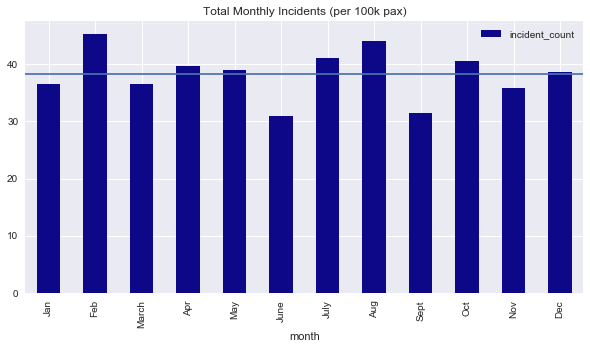

In [87]:
summary_df = delay.copy()

#
monthly_ridership = pd.read_csv('data/monthly_ridership.csv')
monthly_ridership['date'] = pd.to_datetime(monthly_ridership['Year'].astype(str) + monthly_ridership['Period'], format='%Y%b')
monthly_ridership = monthly_ridership[(monthly_ridership['date'] >  pd.to_datetime('2013-12-01'))]
monthly_ridership.set_index(['date'],inplace=True)

# count for frequency per hour

summary_df['count'] = summary_df.groupby('date')['date'].transform('count')
summary_df = summary_df.drop_duplicates(subset=['date']).set_index('date').fillna(summary_df.bfill())
summary_df['ridership'] = monthly_ridership[['Value']]

time_series_df = summary_df.resample('MS')['count'].sum()
ridership_series_df = monthly_ridership.resample('MS')['Value'].sum()

normalized = time_series_df / (ridership_series_df / 1000000)

normalized = pd.DataFrame({'date':normalized.index, 'incident_count':normalized.values}).dropna()
normalized['month'] = [i.month for i in normalized['date']]


normalized['count'] = normalized.groupby('month')['incident_count'].sum()
normalized = normalized.dropna().sort_values('month')
plot = normalized.set_index('month')[['incident_count']].plot(kind='bar', colormap='plasma', title="Total Monthly Incidents (per 100k pax)", figsize=(10,5))
plot.axhline(y=normalized['incident_count'].mean())
plot.set_xticklabels(['Jan', 'Feb', 'March', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

C:\Users\kyleb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


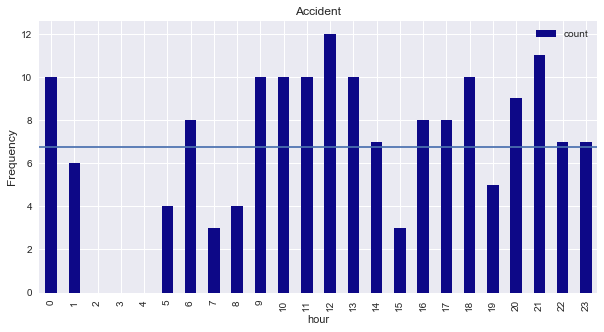

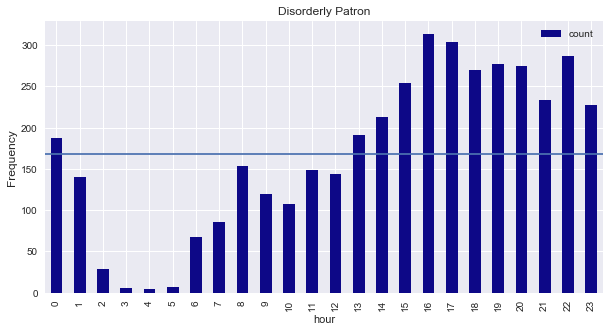

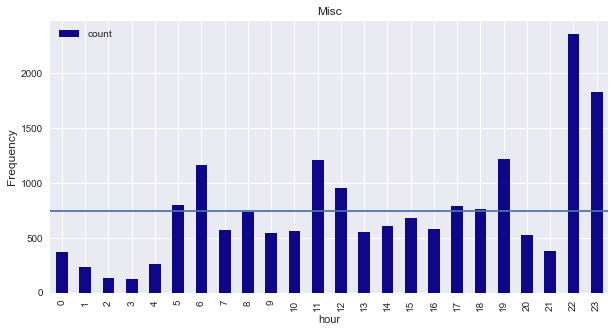

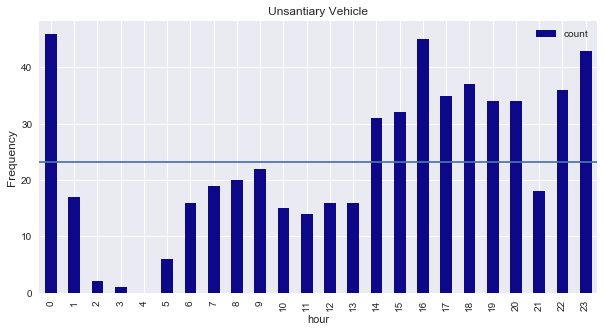

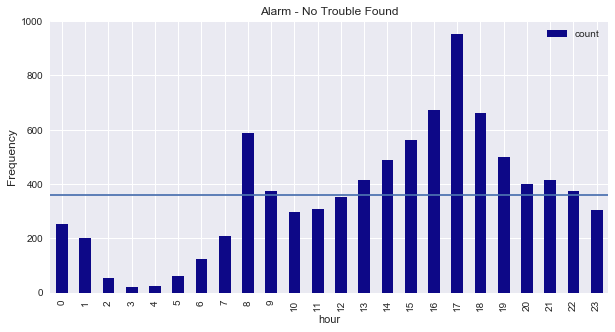

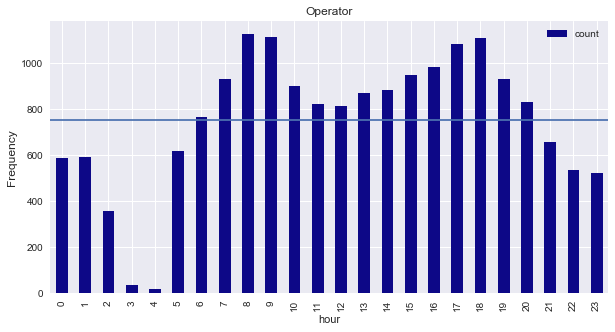

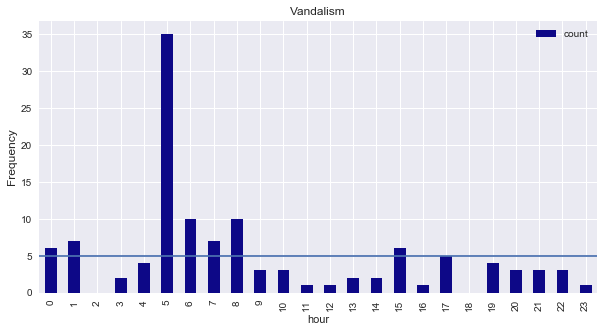

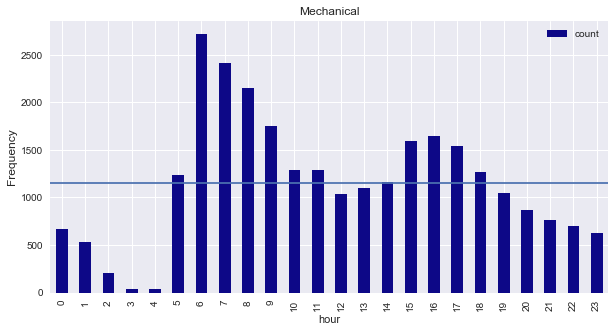

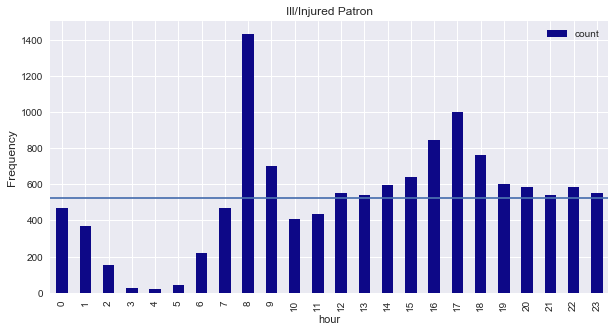

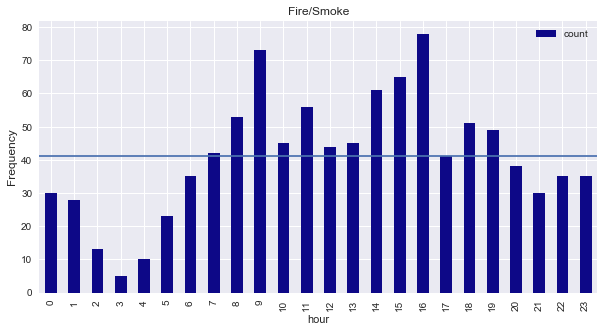

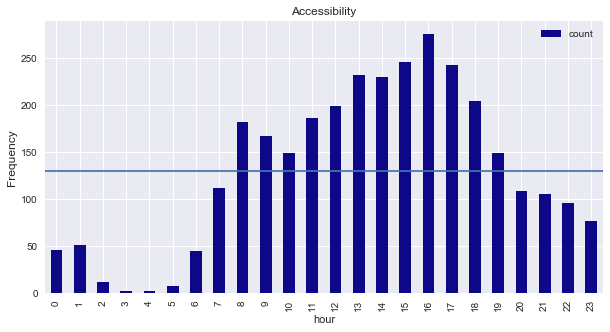

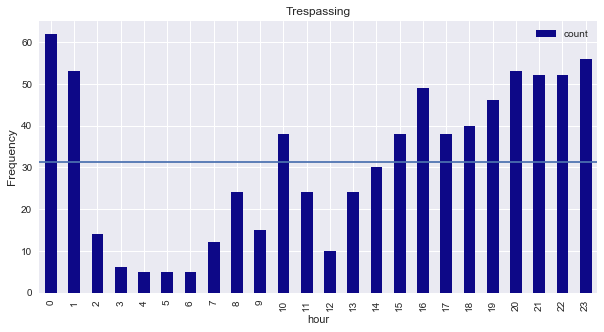

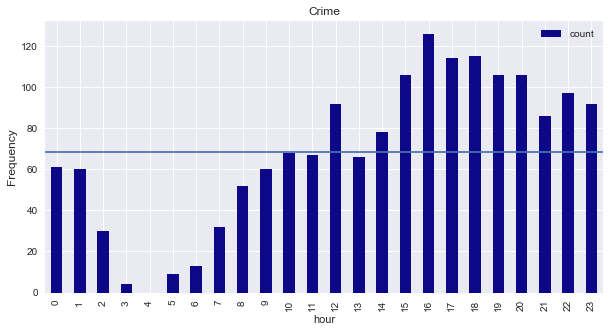

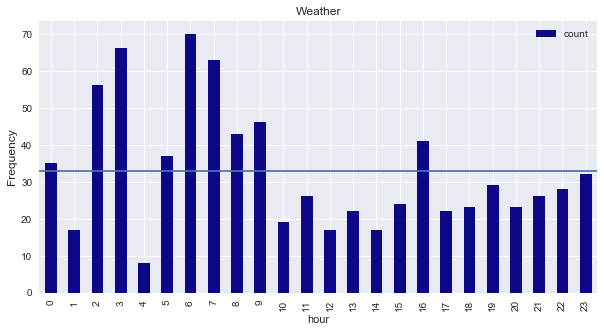

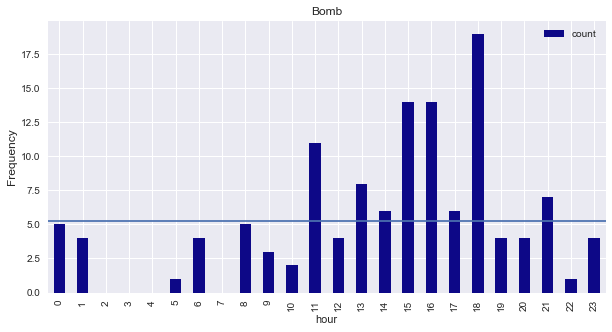

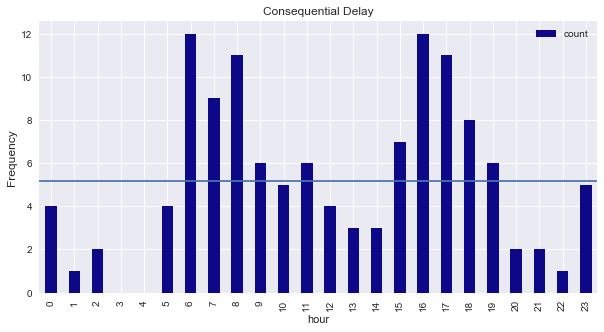

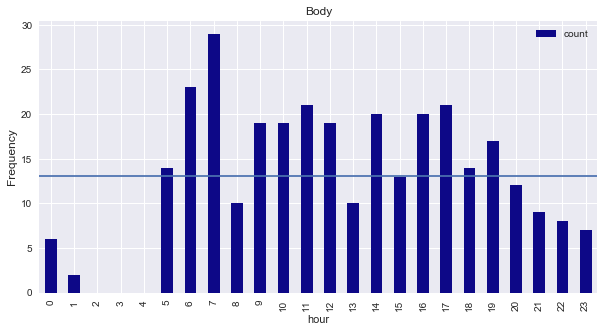

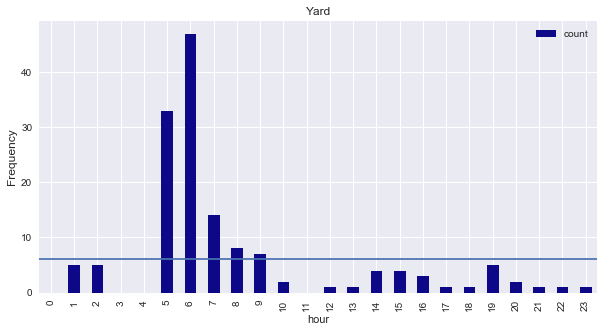

In [90]:
for code_bin in unique_code_bins:
    # filter out by code_bin
    sorted_by_code_bin = delay[delay['code_bin']==code_bin]
    # count for frequency per hour
    sorted_by_code_bin['count'] = sorted_by_code_bin.groupby('hour')['hour'].transform('count')
    sorted_df = sorted_by_code_bin[['code_bin', 'hour', 'count']].drop_duplicates(subset=['code_bin', 'hour']).sort_values(['code_bin', 'hour'])
    # fill out hour
    new_index = range(0,24)
    cleaned_df = sorted_df.set_index("hour").reindex(new_index).reset_index()
    cleaned_df['code_bin'] = cleaned_df['code_bin'].fillna(unique_code_bins[3])
    cleaned_df['count'] = cleaned_df['count'].fillna(0)
    
    #plot
    plot = cleaned_df.plot(kind='bar', x='hour', y='count', colormap='plasma', title=code_bin, figsize=(10,5))
    plot.set_ylabel("Frequency",fontsize=12)
    plot.axhline(y=cleaned_df['count'].mean())

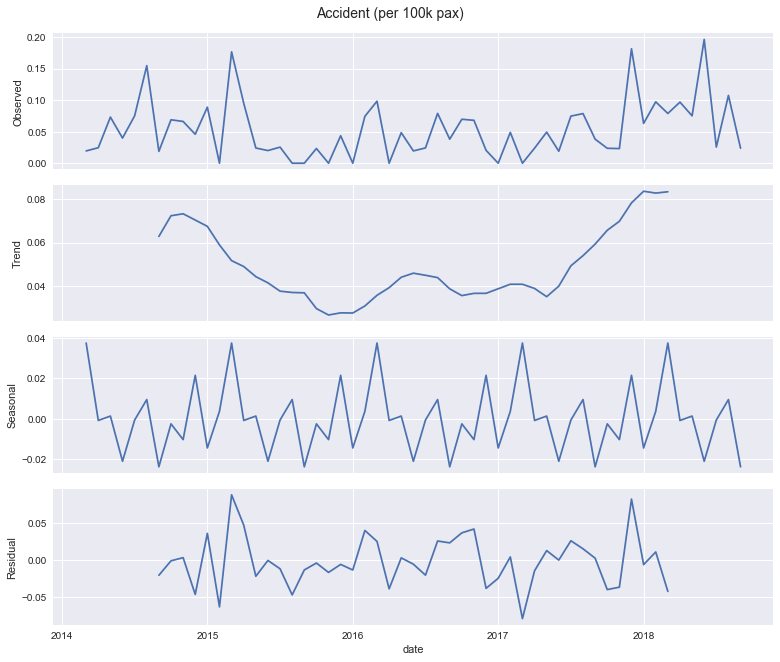

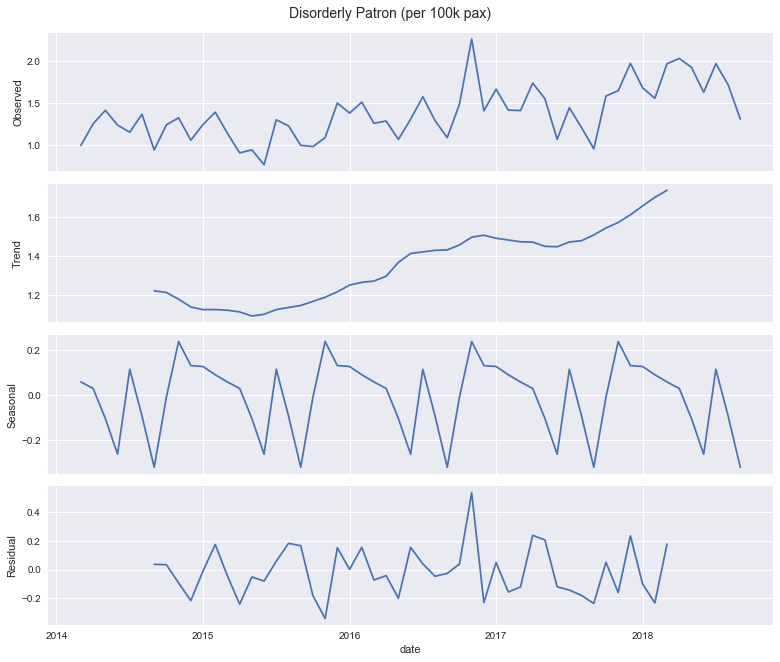

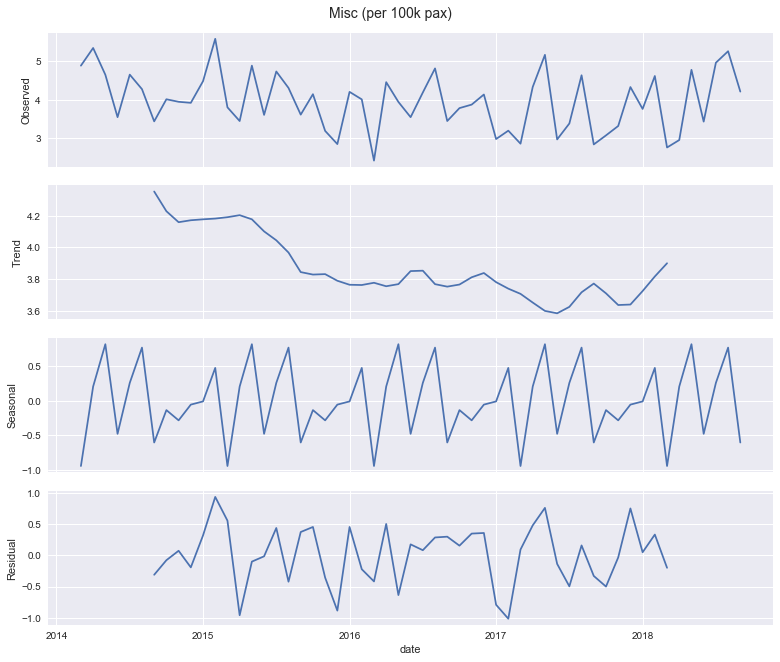

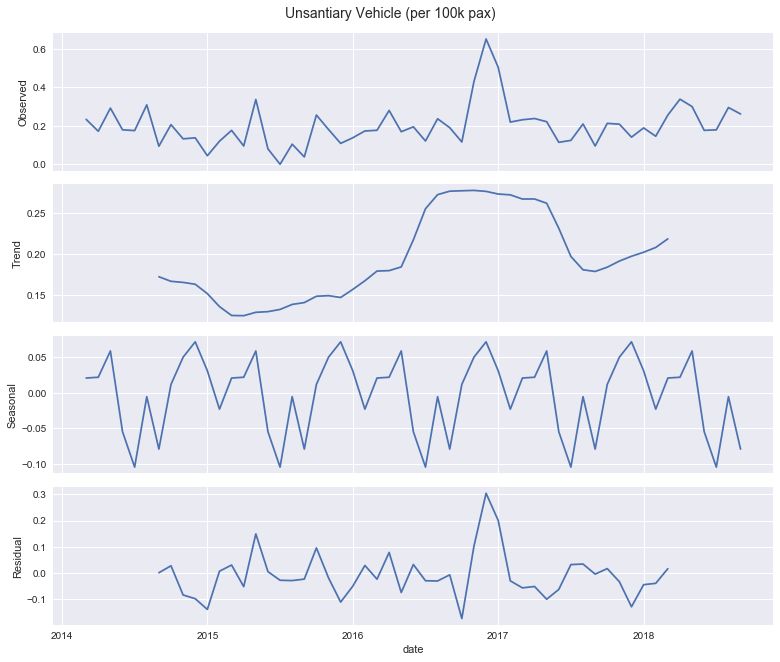

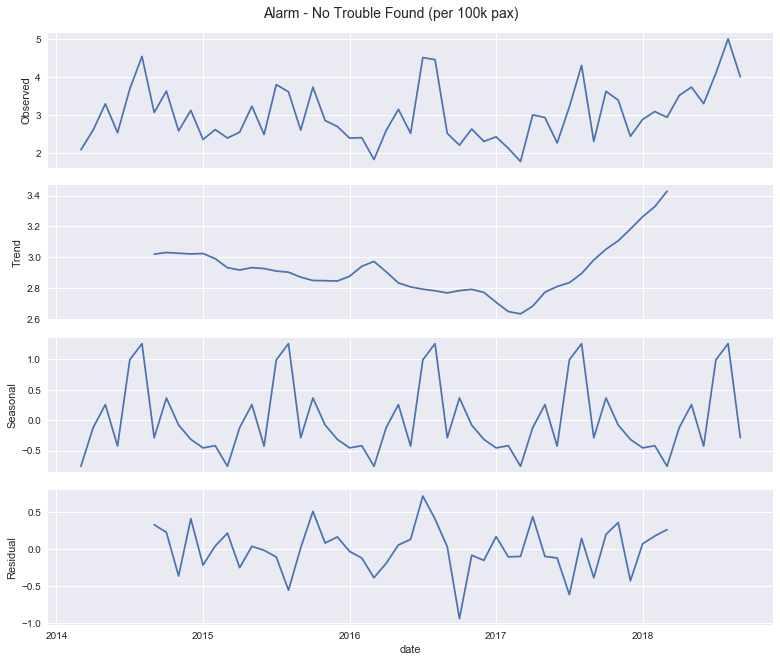

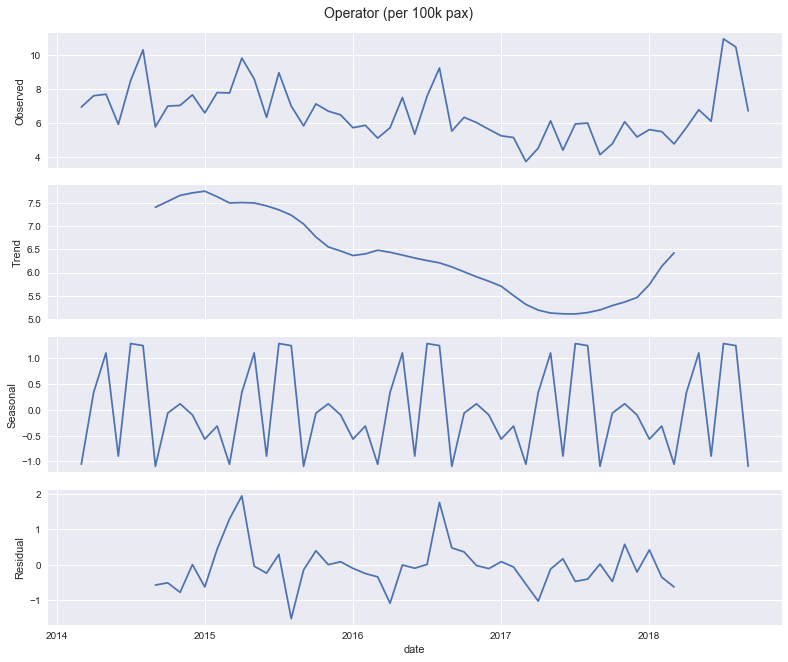

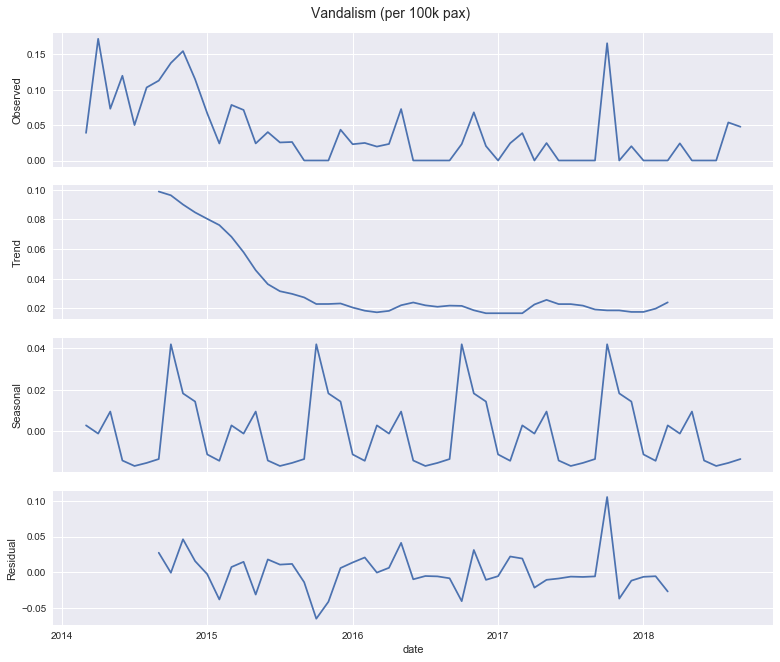

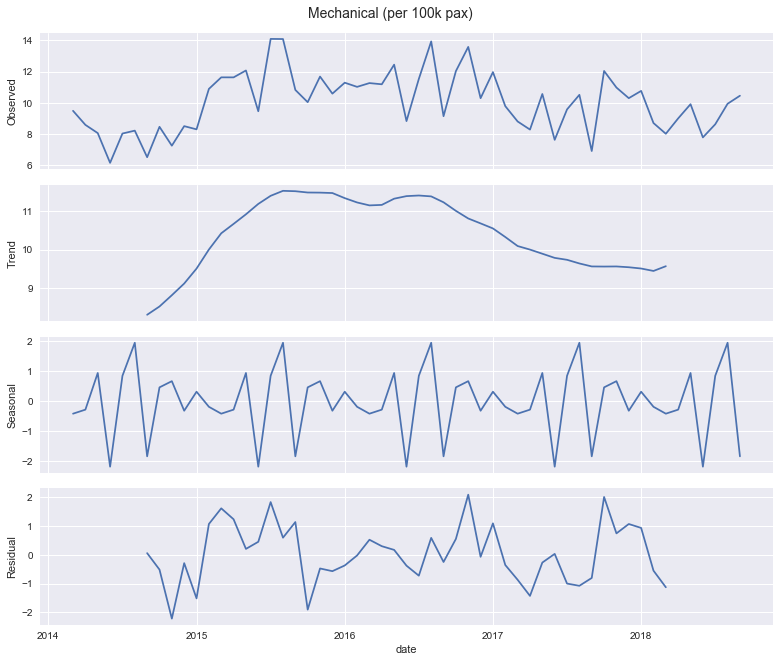

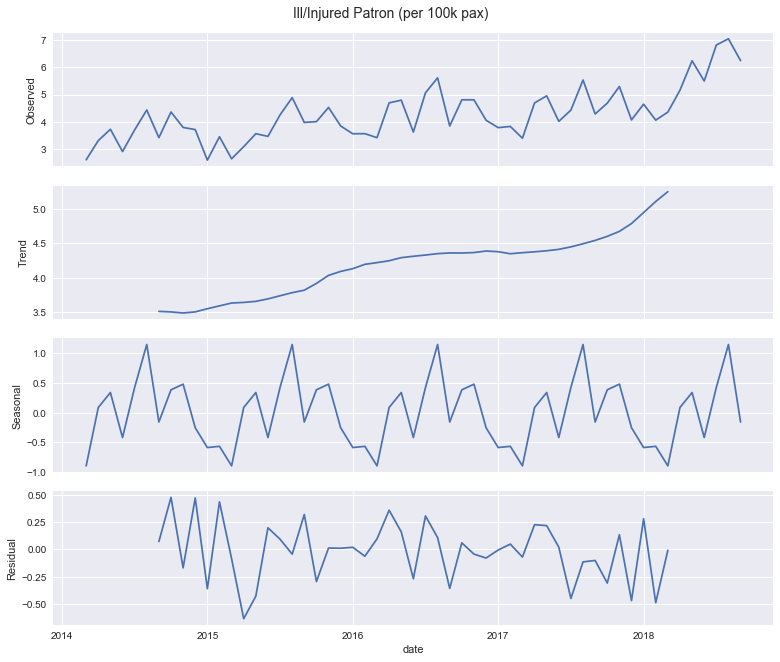

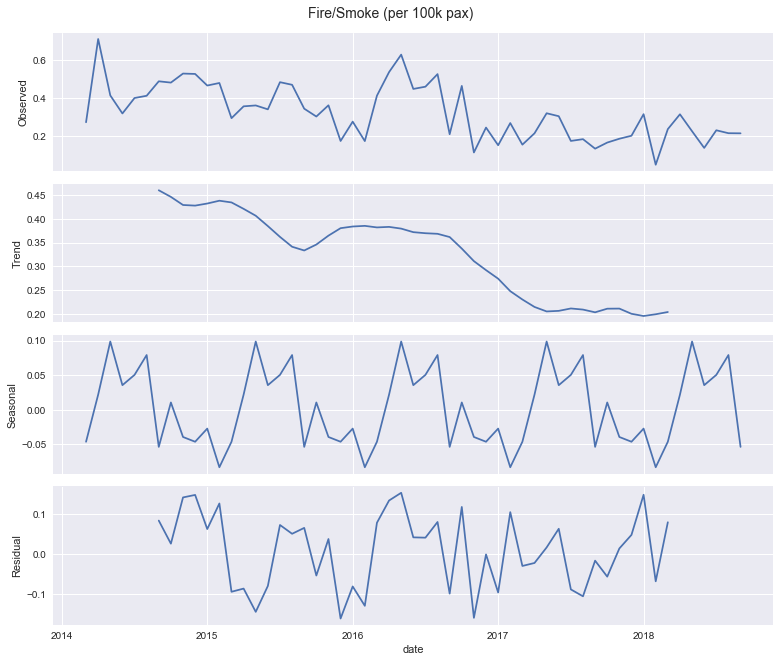

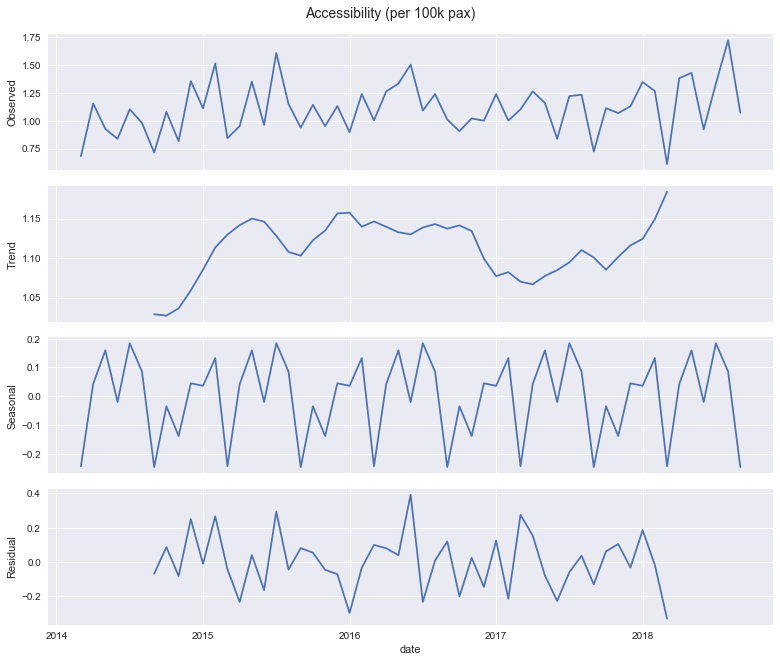

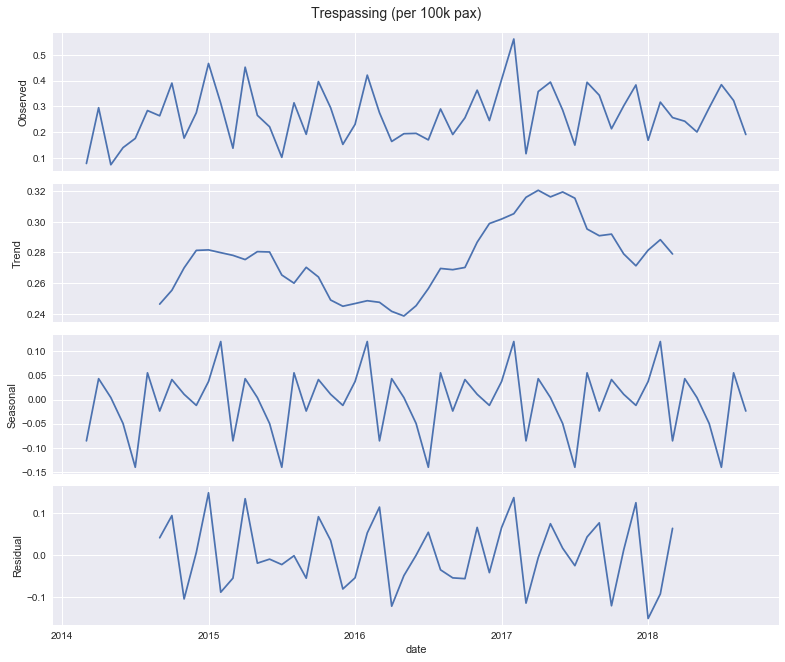

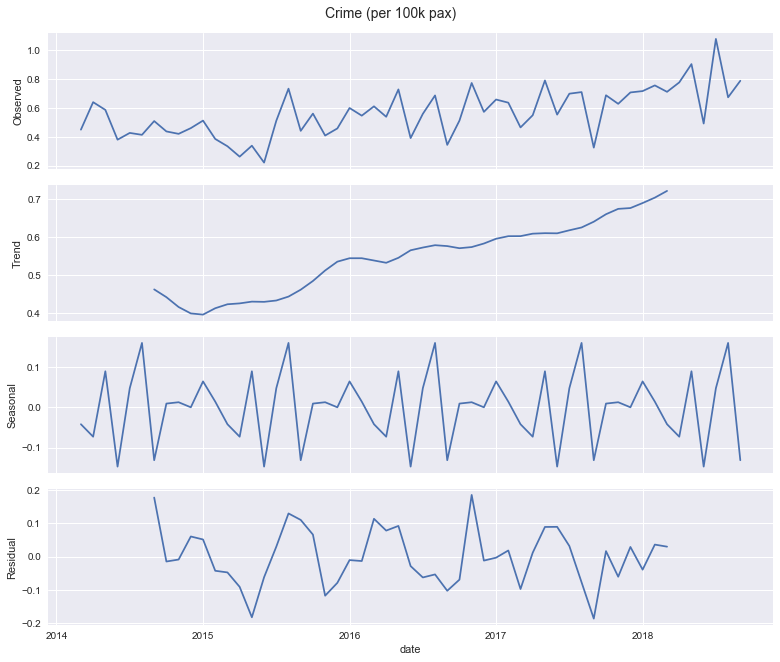

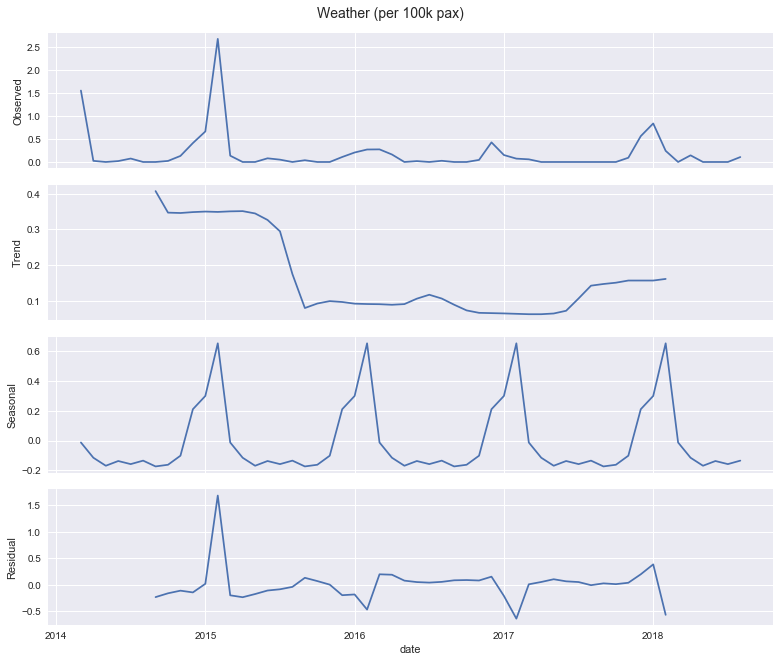

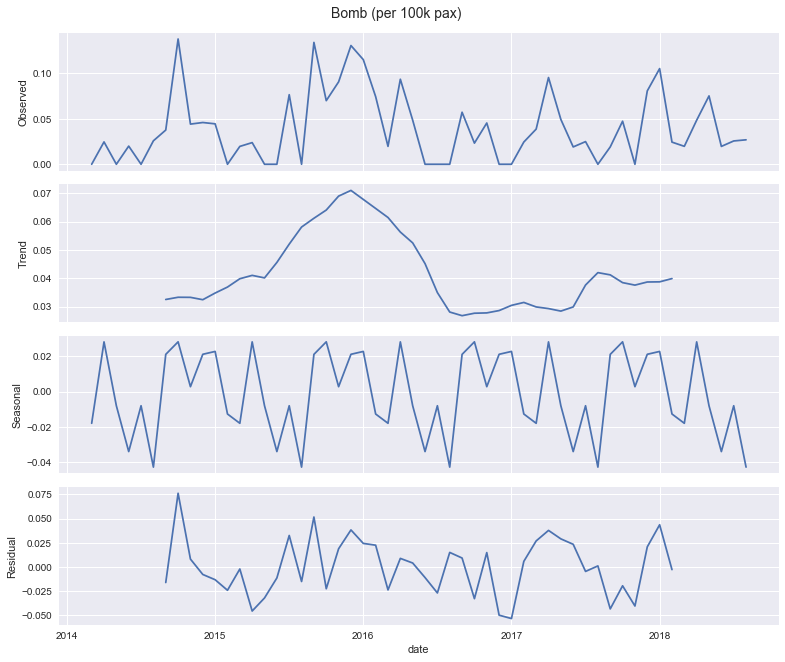

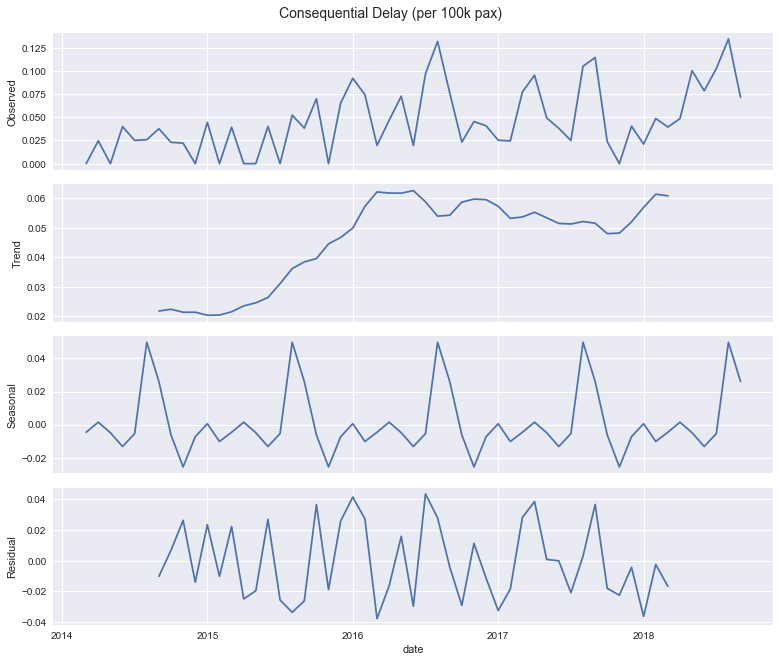

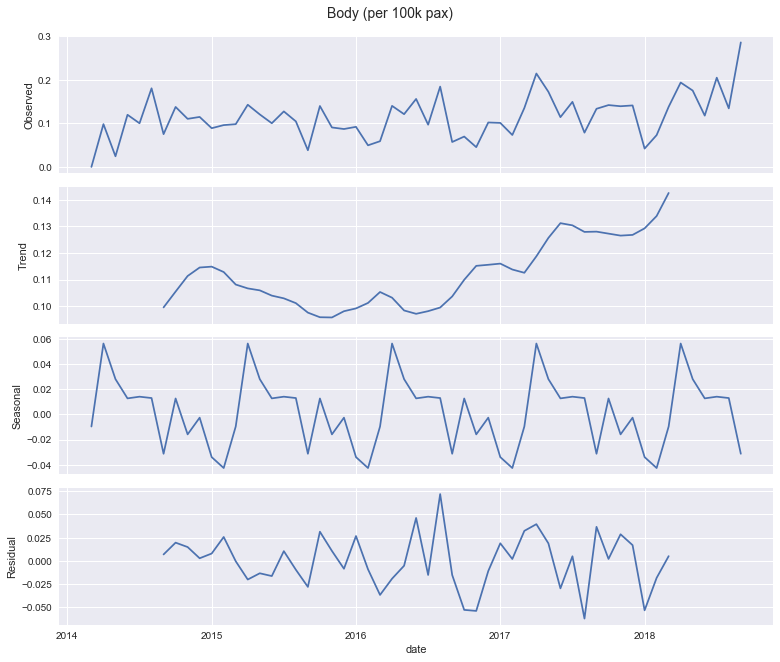

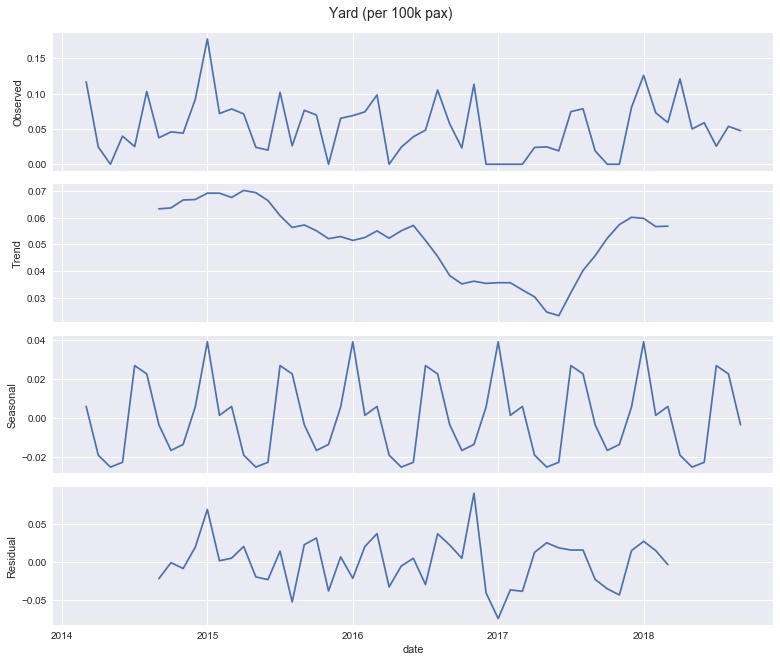

In [91]:
# Monthly trend analysis per incident category

for code_bin in unique_code_bins:
    #
    monthly_ridership = pd.read_csv('data/monthly_ridership.csv')
    monthly_ridership['date'] = pd.to_datetime(monthly_ridership['Year'].astype(str) + monthly_ridership['Period'], format='%Y%b')
    monthly_ridership = monthly_ridership[(monthly_ridership['date'] >  pd.to_datetime('2014-02-01'))]
    monthly_ridership.set_index(['date'],inplace=True)

    # filter out by code_bin
    summary_df = delay[delay['code_bin']==code_bin].dropna()
    # count for frequency per hour

    summary_df['count'] = summary_df.groupby('date')['date'].transform('count')
    summary_df = summary_df.drop_duplicates(subset=['date']).set_index('date').fillna(summary_df.bfill())
    summary_df['ridership'] = monthly_ridership[['Value']]
    
    time_series_df = summary_df.resample('MS')['count'].sum()
    ridership_series_df = monthly_ridership.resample('MS')['Value'].sum()

    normalized = time_series_df / (ridership_series_df / 1000000)
    
    rcParams['figure.figsize'] = 11, 9

    decomposition = sm.tsa.seasonal_decompose(normalized.dropna(), model='additive')
    fig = decomposition.plot()
    plt.set_cmap('plasma')
    plt.suptitle(t=code_bin + ' (per 100k pax)', y=1.02, fontsize=14)
    plt.show()







## b. Efficiency Metrics and Trends

In [81]:
# What types of delays are the most time consuming to correct?
efficiency = delay[['year','code_bin','min_delay']].groupby(['code_bin','year']).mean().unstack()
efficiency.columns = efficiency.columns.droplevel()
efficiency = efficiency.sort_values(2018, ascending=False)
efficiency.head()

year,2014,2015,2016,2017,2018
code_bin,,,,,
Accident,51.825000,99.269231,61.576923,75.812500,58.763158
Bomb,16.444444,14.466667,8.076923,14.833333,42.727273
Fire/Smoke,12.091837,12.900862,16.147186,13.030534,14.556701
Trespassing,7.655462,8.155280,9.275641,8.756345,9.177966
Weather,2.934932,1.990826,1.745098,1.910112,4.280899


In [82]:
# Map efficiency bins
lowEff = efficiency[2018].head(4).index.tolist()
highEff = set(efficiency.index.tolist()) - set(lowEff)

effDict = {}

# Convert reasons to efficiency
for cb in lowEff:
    effDict[cb] = 'low efficiency'
for cb in highEff:
    effDict[cb] = 'high efficiency'

delay['efficiency_bin'] = delay['code_bin'].map(effDict)

C:\Users\kyleb\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0.5,0,'Pct Change in Delay Efficiency (%)')

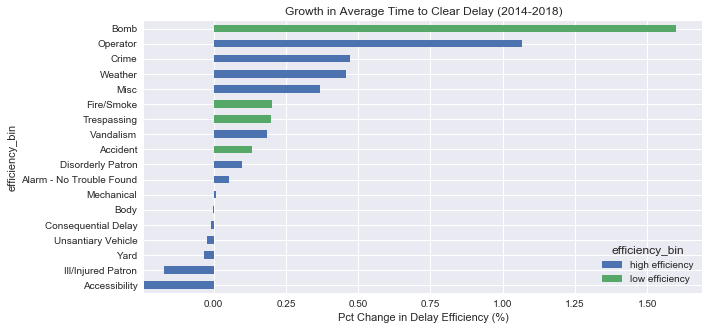

In [83]:
# Get Efficiency Trends by Year
eff_annual = delay[['code_bin','year','min_delay']].groupby(['year','code_bin']).mean()
eff_annual = eff_annual.sort_values(['code_bin','year']).unstack().pct_change(4).dropna()
eff_annual.columns = eff_annual.columns.droplevel()
eff_annual = pd.melt(eff_annual, id_vars=['year'], value_vars=eff_annual.columns.tolist()).drop(columns='year',axis=1)

# Sort data and generate efficiency bins
eff_annual['efficiency_bin'] = eff_annual['code_bin'].map(effDict)

eff_annual = eff_annual.groupby(['code_bin','efficiency_bin']).sum().unstack().reset_index()
eff_annual.columns = eff_annual.columns.droplevel()
eff_annual['sum'] = eff_annual['high efficiency'].fillna(eff_annual['low efficiency'])
eff_annual = eff_annual.rename(columns={'':'efficiency_bin'}).sort_values('sum',ascending=True)
eff_annual = eff_annual.reset_index()
eff_annual.index = eff_annual['efficiency_bin']
ax = eff_annual[['high efficiency','low efficiency']].plot(kind='barh', stacked=True, 
                                                          title='Growth in Average Time to Clear Delay (2014-2018)')
ax.set_xlabel('Pct Change in Delay Efficiency (%)')

In [84]:
# Identify PCT of Total Time Spent on Low Efficiency/High Efficiency Delays
eb_sum = delay[['efficiency_bin','min_delay']].groupby('efficiency_bin').sum()
eb_sum/eb_sum.sum()

,min_delay
efficiency_bin,
high efficiency,0.824519
low efficiency,0.175481


In [85]:
# Identify PCT of Total Alarms on Low Efficiency/High Efficiency of Delays
eb_count = delay[['efficiency_bin','min_delay']].groupby('efficiency_bin').count()
eb_count/eb_count.sum()

,min_delay
efficiency_bin,
high efficiency,0.979279
low efficiency,0.020721


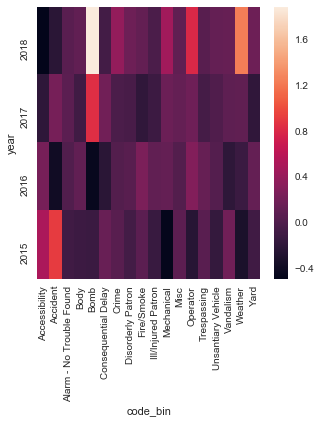

In [86]:
# Identify Per Year Changes
# Get Efficiency Trends by Year
eff_annual = delay[['code_bin','year','min_delay']].groupby(['year','code_bin']).mean()
eff_annual = eff_annual.sort_values(['code_bin','year']).unstack().pct_change(1).dropna()

eff_annual.columns = eff_annual.columns.droplevel()
eff_annual = eff_annual.sort_values('year', ascending=False)
eff_annual
sns.set(rc={'figure.figsize':(5,5)})
sns.heatmap(data = eff_annual)

In [87]:
eff_annual

code_bin,Accessibility,Accident,Alarm - No Trouble Found,Body,Bomb,Consequential Delay,Crime,Disorderly Patron,Fire/Smoke,Ill/Injured Patron,Mechanical,Misc,Operator,Trespassing,Unsantiary Vehicle,Vandalism,Weather,Yard
year,,,,,,,,,,,,,,,,,,
2018,-0.489938,-0.224888,0.062418,0.108285,1.880490,-0.064171,0.389367,0.169706,0.117122,-0.025505,0.460906,0.100099,0.802638,0.048150,0.127174,0.137255,1.241176,0.169655
2017,-0.197521,0.231184,0.067481,-0.083668,0.836508,0.198898,-0.020563,-0.038718,-0.193015,-0.118963,0.158991,0.127702,0.177972,-0.055985,0.008653,0.092857,0.094559,-0.193548
2016,0.225150,-0.379698,0.016545,0.105178,-0.441687,-0.226563,0.028252,0.048745,0.251636,0.111040,0.124743,0.020768,0.295134,0.137379,0.030527,-0.196787,-0.123430,0.126773
2015,0.516929,0.915470,-0.085434,-0.110779,-0.120270,0.144208,0.051653,-0.068607,0.066907,-0.131292,-0.471167,0.079983,-0.249158,0.065289,-0.164521,0.188409,-0.321679,-0.091578


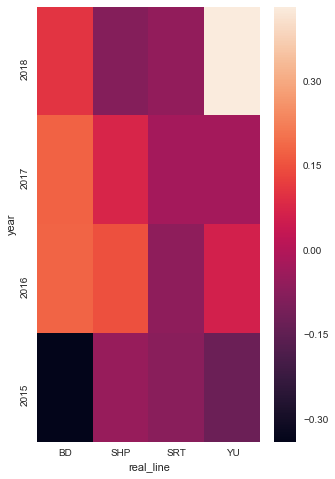

In [88]:
# Identify yearly efficiency metrics by line
line_efficiency = delay[['year','real_line','min_delay']].groupby(['year','real_line']).mean().unstack().pct_change(1).dropna()
line_efficiency = line_efficiency.sort_values('year', ascending=False)


line_efficiency.columns = line_efficiency.columns.droplevel()
sns.set(rc={'figure.figsize':(5,8)})
sns.heatmap(line_efficiency)


In [89]:
line_efficiency.round(2)

real_line,BD,SHP,SRT,YU
year,,,,
2018,0.10,-0.08,-0.06,0.43
2017,0.18,0.07,-0.02,-0.02
2016,0.18,0.15,-0.06,0.06
2015,-0.34,-0.05,-0.07,-0.13


In [90]:
line2 = delay[['year','real_line','min_delay']].groupby(['year','real_line']).mean().unstack()
line2.columns = line2.columns.droplevel()
line2.round(2)

real_line,BD,SHP,SRT,YU
year,,,,
2014,2.11,2.71,3.82,1.98
2015,1.39,2.57,3.54,1.73
2016,1.64,2.96,3.31,1.83
2017,1.93,3.18,3.23,1.79
2018,2.14,2.92,3.04,2.56


## c. Correlation between Min Delay and Min Gap


In [91]:
# How are Minimum Delay & Min Gap Correlated
gd_corr = delay[['code_bin','min_gap','min_delay']].groupby(['code_bin']).corr()
gd_corr['corr'] = gd_corr.apply(lambda x: min(x), axis=1)
gd_corr = gd_corr.reset_index()
gd_corr = gd_corr.drop(columns=['min_delay','min_gap','level_1'],axis=1).drop_duplicates()
gd_corr['efficiency_bin'] = gd_corr['code_bin'].map(effDict)
gd_corr = gd_corr.groupby(['code_bin','efficiency_bin']).sum().unstack().reset_index()
gd_corr.columns = gd_corr.columns.droplevel()
gd_corr['sum'] = gd_corr['high efficiency'].fillna(gd_corr['low efficiency'])
gd_corr = gd_corr.rename(columns={'':'efficiency_bin'}).sort_values('sum', ascending=True)
gd_corr = gd_corr.reset_index()
gd_corr.index = gd_corr['efficiency_bin']

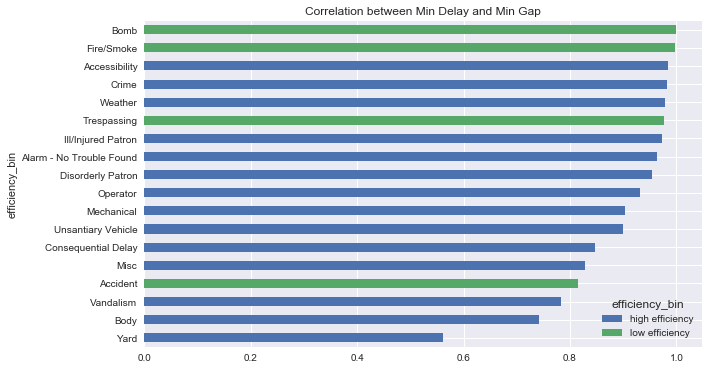

In [92]:
# Plot correlations
sns.set(rc={'figure.figsize':(10,6)})
ax = gd_corr[['high efficiency','low efficiency']].plot(kind='barh', 
                                                       stacked=True, 
                                                       title='Correlation between Min Delay and Min Gap')


In [93]:
# Identify correlation by Efficiency Bin
ebin_corr = delay[['efficiency_bin','min_gap','min_delay']].groupby('efficiency_bin').corr()
ebin_corr['corr'] = ebin_corr.min(axis=1)
ebin_corr = ebin_corr.reset_index()
ebin_corr = ebin_corr.drop(columns=['min_gap','min_delay','level_1'], axis=1).drop_duplicates()
ebin_corr.index = ebin_corr['efficiency_bin']

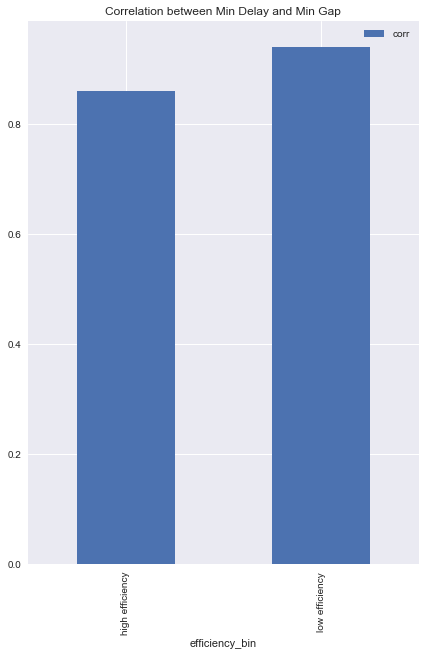

In [607]:
ebin_corr.plot(kind='bar', title='Correlation between Min Delay and Min Gap')